In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from plotly.offline import init_notebook_mode, iplot
import plotly.graph_objs as go
from plotly import tools
import json
from tqdm import tqdm
import gc
import datetime
init_notebook_mode(connected=True)

import sys
import os
sys.path.append(os.path.join(os.getcwd(), '../../'))
%load_ext autoreload
%autoreload 2
import tools4kaggle as t4k
from tools4kaggle.eda import train_test_dist

In [2]:
from tools4kaggle.utils import to_lowerbit

## データ読み込み

In [3]:
%time sample_df = pd.read_parquet('../input/sample.parquet')
%time train_df = pd.read_parquet('../input/train.parquet')
%time test_df = pd.read_parquet('../input/test.parquet')

CPU times: user 7.81 s, sys: 4.59 s, total: 12.4 s
Wall time: 3.95 s
CPU times: user 32.8 s, sys: 23.9 s, total: 56.7 s
Wall time: 24.4 s
CPU times: user 29.5 s, sys: 22 s, total: 51.5 s
Wall time: 21.7 s


### データタイプで分類

In [4]:
with open('../input/new_types.json','r') as f :
    new_types = json.load(f)
sample_df = sample_df.astype(new_types)
train_df = train_df.astype(new_types)
new_types.pop('HasDetections')
test_df = test_df.astype(new_types)

In [5]:
type_names = [str(a) for a in sample_df.dtypes.values]
category_mask = [type_name == 'category' for type_name in type_names]
int_mask   = ['int' in type_name for type_name in type_names]
float_mask = ['float' in type_name for type_name in type_names]

# データクレンジング

### SmartScreen のエレメント統一

In [6]:
def smart_screen_mapping_fun(elem):
    mapping = {
        'Off':'off',
        'OFF':'off',
        'On':'on',
        'ON':'on'
    }
    mapped_option = mapping[elem] if elem in mapping.keys() else None
    if mapped_option == None:
        return elem
    else:
        return mapped_option

In [19]:
train_df['SmartScreen'] = train_df.SmartScreen.apply(smart_screen_mapping_fun).astype('category')
sample_df['SmartScreen'] = sample_df.SmartScreen.apply(smart_screen_mapping_fun).astype('category')
test_df['SmartScreen'] = test_df.SmartScreen.apply(smart_screen_mapping_fun).astype('category')

## category タイプ分析

In [8]:
sample_df.iloc[:,category_mask].describe().T\
    .assign(count_na=sample_df.iloc[:,category_mask].isna().sum())

,count,unique,top,freq,count_na
MachineIdentifier,892148,892148,19a21482d093d9038090905513ade462,1,0
ProductName,892148,5,win8defender,882619,0
EngineVersion,892148,60,1.1.15200.1,385189,0
AppVersion,892148,94,4.18.1807.18075,514821,0
AvSigVersion,892148,7240,1.273.1420.0,10307,0
Platform,892148,4,windows10,861795,0
Processor,892148,3,x64,810662,0
OsVer,892148,19,10.0.0.0,863203,0
OsPlatformSubRelease,892148,9,rs4,391028,0
OsBuildLab,892146,501,17134.1.amd64fre.rs4_release.180410-1804,365326,2


## int タイプ分析

In [9]:
sample_df.describe(percentiles=[0.5],include=['int8','int16']).T \
    .assign(count_na=sample_df.iloc[:,int_mask].isna().sum()) \
    .assign(unique=sample_df.iloc[:,int_mask].nunique()) \
    .loc[:,['count','unique','min','max','count_na','mean','50%','std']]

,count,unique,min,max,count_na,mean,50%,std
IsBeta,892148.0,2,0.0,1.0,0,0.000007,0.0,0.002593
IsSxsPassiveMode,892148.0,2,0.0,1.0,0,0.017333,0.0,0.130511
HasTpm,892148.0,2,0.0,1.0,0,0.987884,1.0,0.109403
CountryIdentifier,892148.0,222,1.0,222.0,0,108.017344,97.0,63.013204
LocaleEnglishNameIdentifier,892148.0,227,-127.0,127.0,0,27.872954,58.0,65.584635
OsBuild,892148.0,53,7600.0,18242.0,0,15718.480049,16299.0,2191.594614
OsSuite,892148.0,10,16.0,784.0,0,575.357658,768.0,248.036214
AutoSampleOptIn,892148.0,2,0.0,1.0,0,0.000031,0.0,0.005602
Census_HasOpticalDiskDrive,892148.0,2,0.0,1.0,0,0.076991,0.0,0.266577
Census_OSBuildNumber,892148.0,79,7601.0,18242.0,0,15833.643513,16299.0,1961.752960


## float タイプ分析

In [10]:
sample_df.iloc[:,float_mask].describe(percentiles=[0.5]).T \
    .assign(count_na=sample_df.iloc[:,float_mask].isna().sum()) \
    .assign(unique=sample_df.iloc[:,float_mask].nunique()) \
    .loc[:,['count','unique','min','max','count_na','mean','50%','std']]

,count,unique,min,max,count_na,mean,50%,std
RtpStateBitfield,888843.0,6,0.000000,8.000000e+00,3305,NaN,7.0,0.000000e+00
DefaultBrowsersIdentifier,43028.0,691,1.000000,3.204000e+03,849120,inf,1632.0,inf
AVProductStatesIdentifier,888489.0,7659,6.000000,7.049200e+04,3659,4.776736e+04,53447.0,1.403618e+04
AVProductsInstalled,888489.0,5,1.000000,5.000000e+00,3659,NaN,1.0,0.000000e+00
AVProductsEnabled,888489.0,6,0.000000,5.000000e+00,3659,NaN,1.0,0.000000e+00
CityIdentifier,859590.0,48402,5.000000,1.679620e+05,32558,8.124721e+04,82373.0,4.895621e+04
OrganizationIdentifier,616460.0,46,1.000000,5.200000e+01,275688,NaN,27.0,0.000000e+00
GeoNameIdentifier,892131.0,271,1.000000,2.960000e+02,17,NaN,181.0,NaN
IsProtected,888505.0,2,0.000000,1.000000e+00,3643,NaN,1.0,0.000000e+00
SMode,838769.0,2,0.000000,1.000000e+00,53379,4.482269e-04,0.0,2.116394e-02


# 学習データとテストデータの比較

In [10]:
overrap_ratio = []
for col_name in tqdm(test_df.drop('MachineIdentifier',axis=1).columns):
    sample_unique_set = sample_df.loc[:,col_name].unique().astype(np.unicode)
    other_unique_set = test_df.loc[:,col_name].unique().astype(np.unicode)
    overrap_ratio.append(np.intersect1d(sample_unique_set, other_unique_set).size / \
                         np.union1d(sample_unique_set, other_unique_set).size)

100%|██████████| 81/81 [00:28<00:00,  2.84it/s]


学習データとテストデータのラベルの種類の重複具合を見る．出現ラベルが少ない割に重複が少ない場合は，その特徴においてデータの性質が大きく異なることを示す．ラベルが多く，重複が少ない場合はあまり使えなさそうなデータである．

上位10個の特徴の分布を確かめる．

In [11]:
overrap = pd.DataFrame({'train_test_overrap_ratio': overrap_ratio},
                      index = test_df.drop('MachineIdentifier',axis=1).columns)
overrap = overrap.assign(train_unique=sample_df.nunique()) \
    .assign(test_unique=test_df.nunique()) \
    .assign(type_name=test_df.dtypes)

In [87]:
overrap.sort_values('train_test_overrap_ratio').iloc[:25,:]

,train_test_overrap_ratio,train_unique,test_unique,type_name
Census_InternalPrimaryDiagonalDisplaySizeInInches,0.101051,557,803,float64
Census_InternalBatteryNumberOfCharges,0.145258,8066,36360,float64
Census_TotalPhysicalRAM,0.155062,827,3700,float64
Census_PrimaryDiskTotalCapacity,0.188554,1532,5797,float64
AVProductStatesIdentifier,0.218294,7659,23492,float64
PuaMode,0.250000,1,2,object
Census_OEMModelIdentifier,0.271443,56352,167776,float64
Census_InternalPrimaryDisplayResolutionHorizontal,0.288570,715,2248,float64
DefaultBrowsersIdentifier,0.290832,691,1757,float64
LocaleEnglishNameIdentifier,0.304910,227,278,int64


### Census_InternalPrimaryDiagonalDisplaySizeInInches

ほぼ同一分布

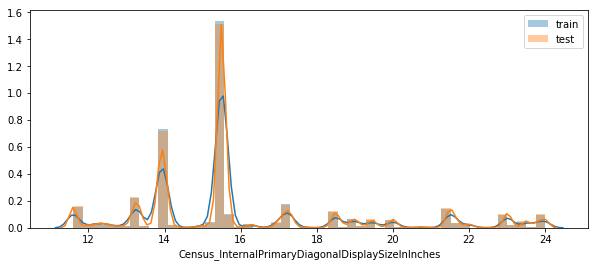

In [14]:
t4k.eda.train_test_dist(sample_df, test_df,'Census_InternalPrimaryDiagonalDisplaySizeInInches', disp_range=0.9)

### Census_TotalPhysicalRAM
ほぼ同一分布

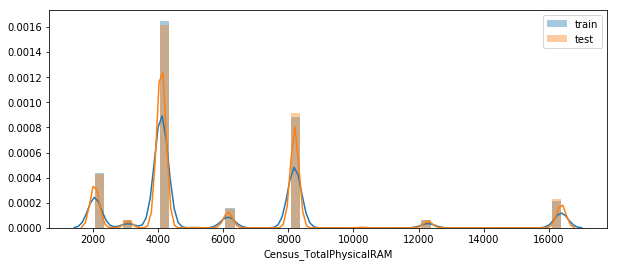

In [15]:
t4k.eda.train_test_dist(sample_df, test_df, 'Census_TotalPhysicalRAM', disp_range=0.9)

### LocaleEnglishNameIdentifier
結構違う．test の方が新しい．

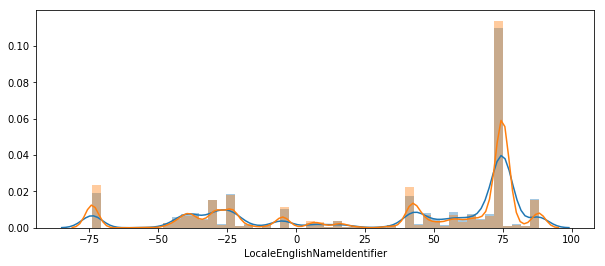

In [148]:
t4k.eda.train_test_dist(sample_df, test_df,'LocaleEnglishNameIdentifier',disp_range=0.8,bins=50)

### Census_OSBuildNumber

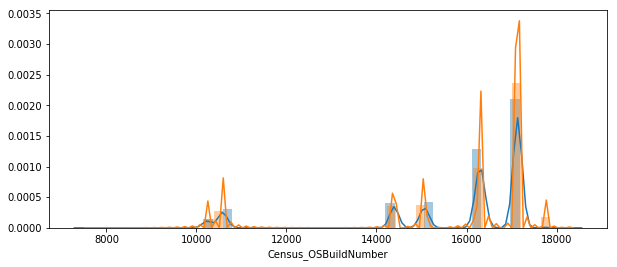

In [152]:
t4k.eda.train_test_dist(sample_df,test_df,'Census_OSBuildNumber')

### SmartScreen

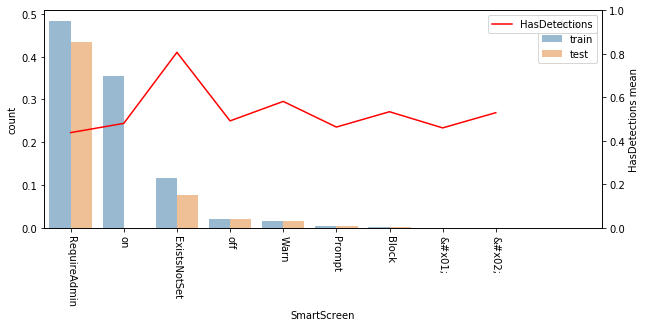

In [20]:
t4k.eda.train_test_dist(sample_df,test_df,'SmartScreen',target_name='HasDetections',disp_num=10)

### Census_ProcessorCoreCount
あまり変わらない

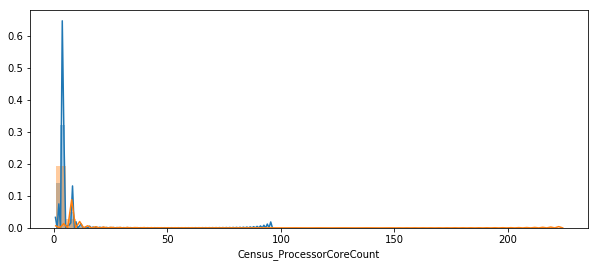

In [154]:
t4k.eda.train_test_dist(sample_df,test_df,'Census_ProcessorCoreCount')

### Census_OSBranch
少し差が出る．

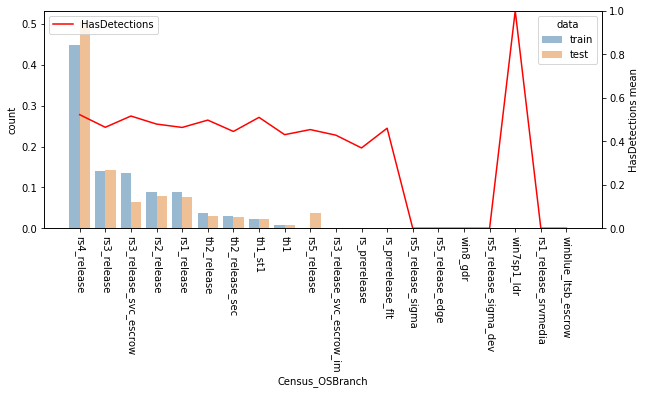

In [233]:
t4k.eda.train_test_dist(sample_df,test_df,'Census_OSBranch',target_name='HasDetections')

### OsBuildLab

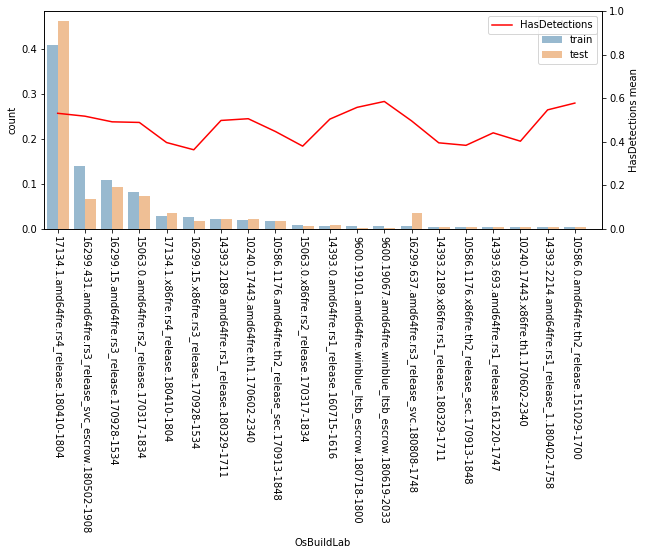

In [234]:
t4k.eda.train_test_dist(sample_df,test_df,'OsBuildLab',target_name='HasDetections',disp_num=20)

## Version 系

### OsVer
あまり変わらない．

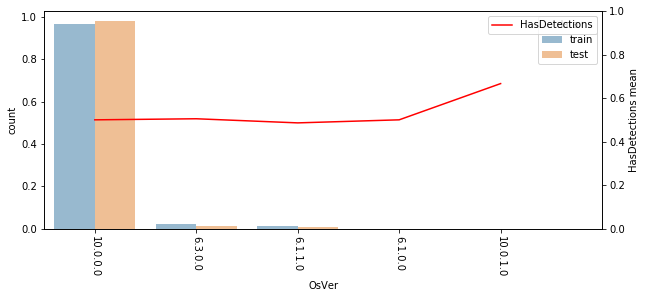

In [236]:
t4k.eda.train_test_dist(sample_df,test_df,'OsVer',target_name='HasDetections',disp_num=5)

### Census_OSVersion

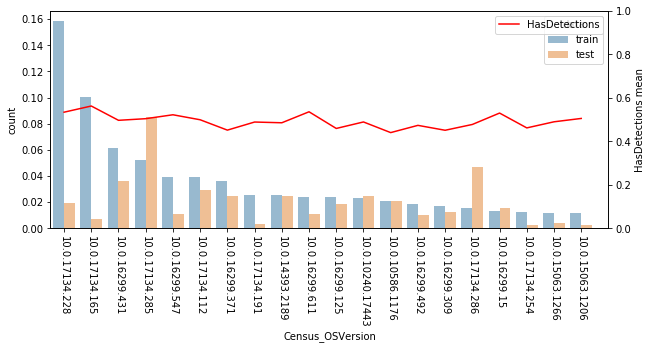

In [237]:
t4k.eda.train_test_dist(sample_df,test_df,'Census_OSVersion',target_name='HasDetections',disp_num=20)

In [185]:
version_df = sample_df.loc[:,['AppVersion','EngineVersion','AvSigVersion','Census_OSVersion']]

ve = t4k.transformer.VersionEncoder()
out = ve.fit_transform(version_df)

test_version_df = test_df.loc[:,['AppVersion','EngineVersion','AvSigVersion','Census_OSVersion']]
test_out = ve.transform(test_version_df)

### AppVersion

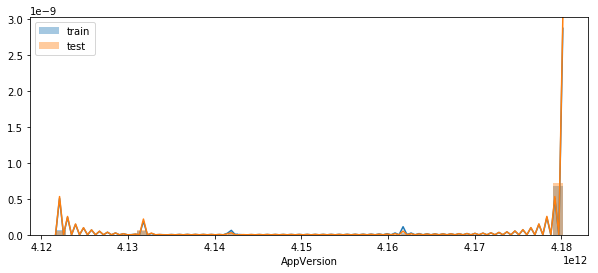

In [313]:
t4k.eda.train_test_dist(out, test_out, 'AppVersion',disp_range=0.7)

### EngineVersion

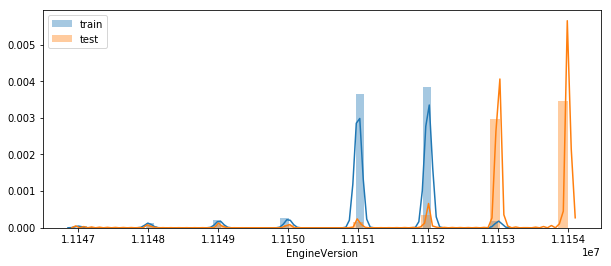

In [186]:
t4k.eda.train_test_dist(out, test_out, 'EngineVersion',disp_range=0.9)

### AvSigVersion

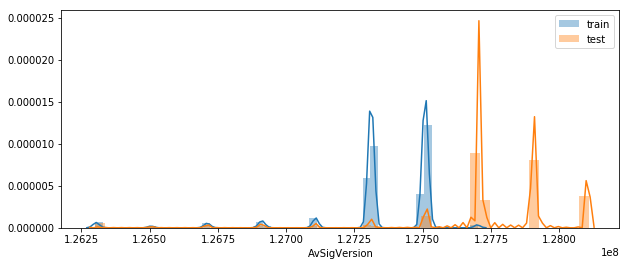

In [321]:
t4k.eda.train_test_dist(out, test_out, 'AvSigVersion',disp_range=0.9)

### Census_OSVersion

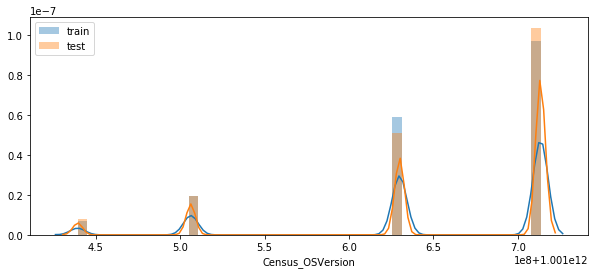

In [316]:
t4k.eda.train_test_dist(out, test_out, 'Census_OSVersion',disp_range=0.7)

## Identifier 系

In [ ]:
identifier_cols = [elem for elem in sample_df.columns  if 'Identifier' in elem]
id_describe = sample_df[identifier_cols].describe().T[['count','min','max']]
id_describe = id_describe.assign(count_na=sample_df.iloc[identifier

In [126]:
identifier_cols = [elem for elem in sample_df.columns  if 'Identifier' in elem]
sample_df[identifier_cols].describe().T[['count','min','max']] \
    .assign(count_na=sample_df[identifier_cols].isna().sum()) \
    .assign(unique=sample_df[identifier_cols].nunique()) \
    .assign(dtype=sample_df[identifier_cols].dtypes)

,count,min,max,count_na,unique,dtype
DefaultBrowsersIdentifier,43028.0,1.0,3204.0,849120,691,float16
AVProductStatesIdentifier,888489.0,6.0,70492.0,3659,7659,float32
CountryIdentifier,892148.0,1.0,222.0,0,222,int16
CityIdentifier,859590.0,5.0,167962.0,32558,48402,float32
OrganizationIdentifier,616460.0,1.0,52.0,275688,46,float16
GeoNameIdentifier,892131.0,1.0,296.0,17,271,float16
LocaleEnglishNameIdentifier,892148.0,-127.0,127.0,0,227,int8
IeVerIdentifier,886178.0,1.0,429.0,5970,206,float16
Census_OEMNameIdentifier,882776.0,1.0,6144.0,9372,1510,float16
Census_OEMModelIdentifier,882066.0,14.0,345494.0,10082,56352,float32


In [154]:
identifier_sample = sample_df[identifier_cols] \
    .applymap(lambda x:'id_{0}'.format(x) if not pd.isnull(x) else np.nan) \
    .astype('category') \
    .assign(HasDetections=sample_df.HasDetections)
identifier_test = test_df[identifier_cols] \
    .applymap(lambda x:'id_{0}'.format(x) if not pd.isnull(x) else np.nan) \
    .astype('category')

### DefaultBrowsersIdentifier

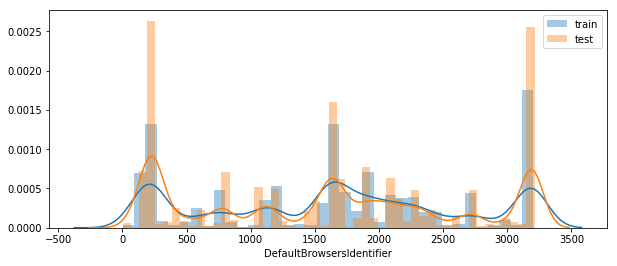

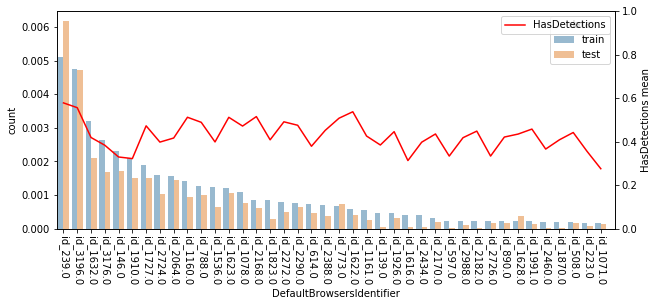

In [238]:
tools4kaggle.eda.train_test_dist(sample_df, test_df, 'DefaultBrowsersIdentifier')
train_test_dist(identifier_sample, identifier_test, 'DefaultBrowsersIdentifier', target_name='HasDetections',disp_num=40)

### CountryIdentifier

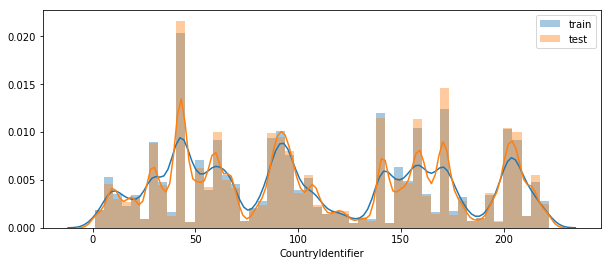

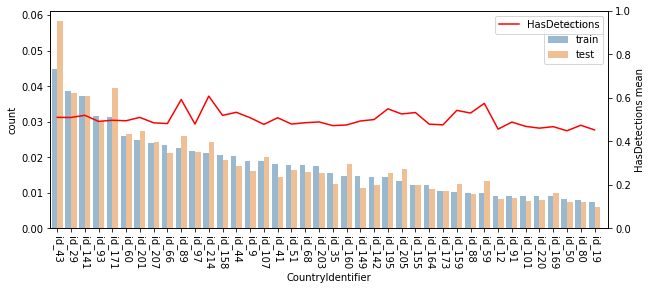

In [220]:
train_test_dist(sample_df, test_df, 'CountryIdentifier')
train_test_dist(identifier_sample, identifier_test, 'CountryIdentifier', target_name='HasDetections',disp_num=40)

### CityIdentifier

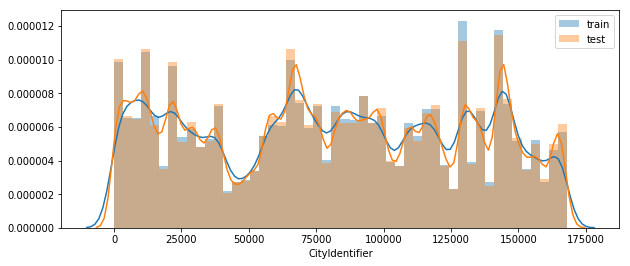

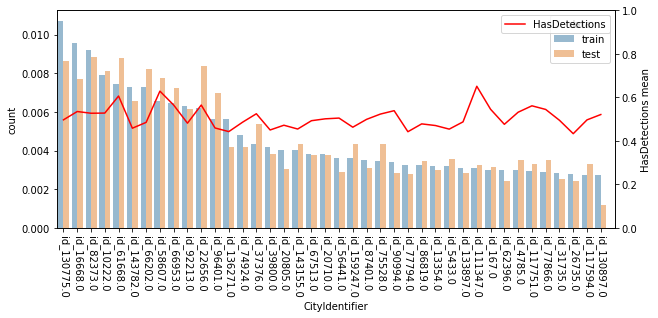

In [221]:
train_test_dist(sample_df, test_df, 'CityIdentifier')
train_test_dist(identifier_sample, identifier_test, 'CityIdentifier', target_name='HasDetections',disp_num=40)

### OrganizationIdentifier

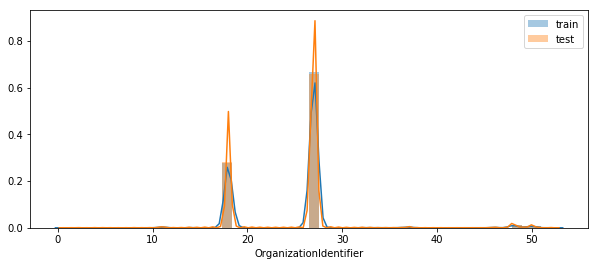

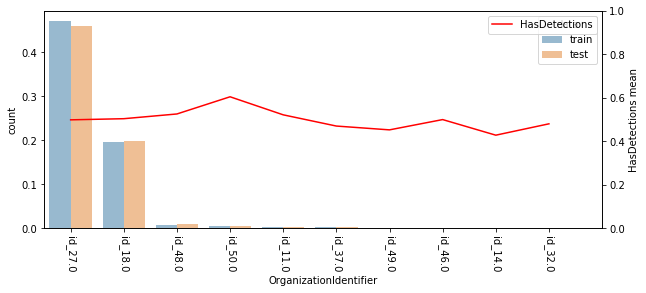

In [222]:
train_test_dist(sample_df, test_df, 'OrganizationIdentifier')
train_test_dist(identifier_sample, identifier_test, 'OrganizationIdentifier', target_name='HasDetections',disp_num=10)

### GeoNameIdentifier

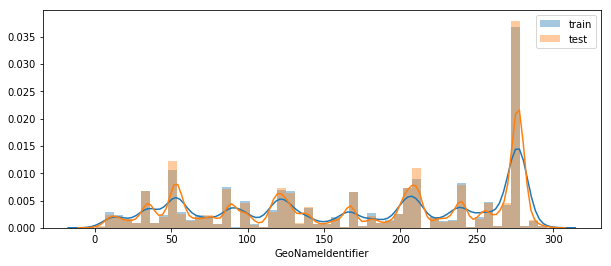

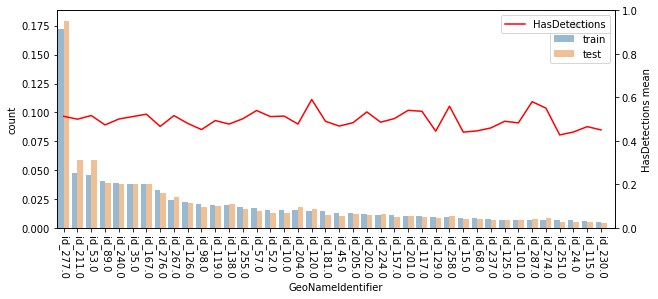

In [223]:
train_test_dist(sample_df, test_df, 'GeoNameIdentifier')
train_test_dist(identifier_sample, identifier_test, 'GeoNameIdentifier', target_name='HasDetections',disp_num=40)

### LocaleEnglishNameIdentifier

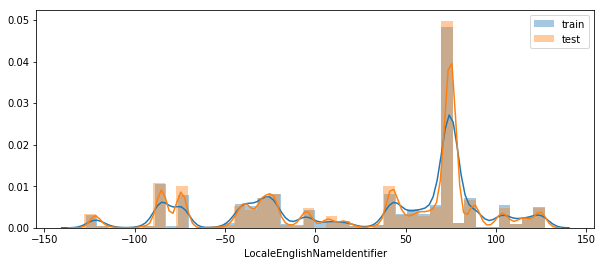

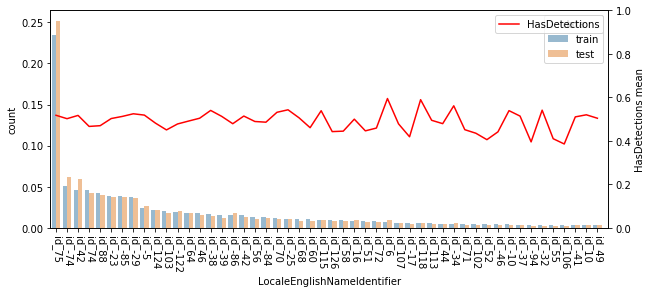

In [224]:
train_test_dist(sample_df, test_df, 'LocaleEnglishNameIdentifier',bins=40)
train_test_dist(identifier_sample, identifier_test, 'LocaleEnglishNameIdentifier', target_name='HasDetections',disp_num=50)

### IeVerIdentifier

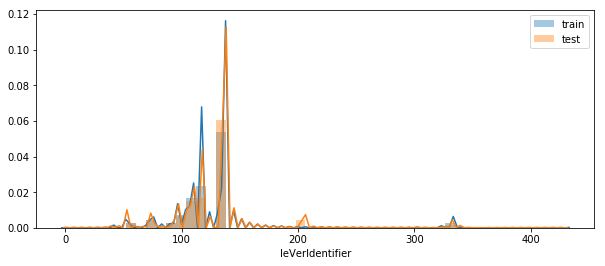

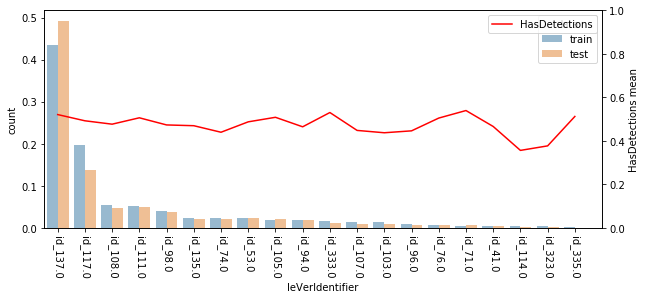

In [225]:
train_test_dist(sample_df, test_df, 'IeVerIdentifier')
train_test_dist(identifier_sample, identifier_test, 'IeVerIdentifier', target_name='HasDetections',disp_num=20)

### Census_OEMNameIdentifier

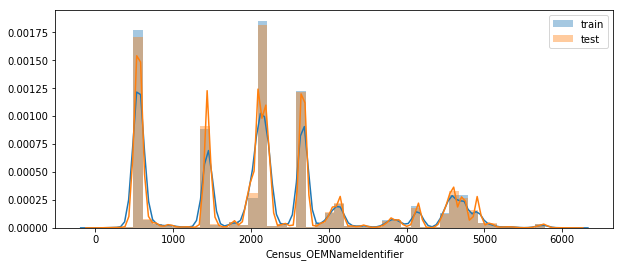

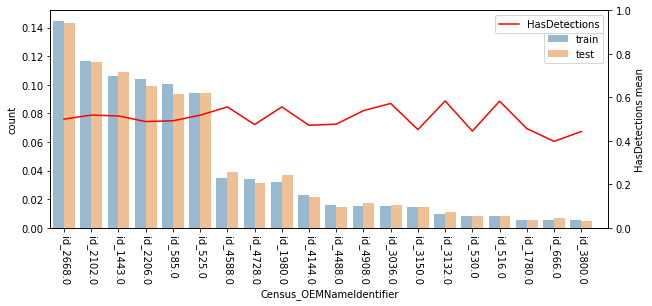

In [219]:
train_test_dist(sample_df, test_df, 'Census_OEMNameIdentifier')
train_test_dist(identifier_sample, identifier_test, 'Census_OEMNameIdentifier', target_name='HasDetections',disp_num=20)

### Census_ProcessorManufacturerIdentifier

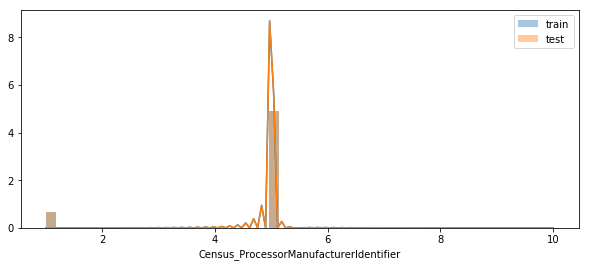

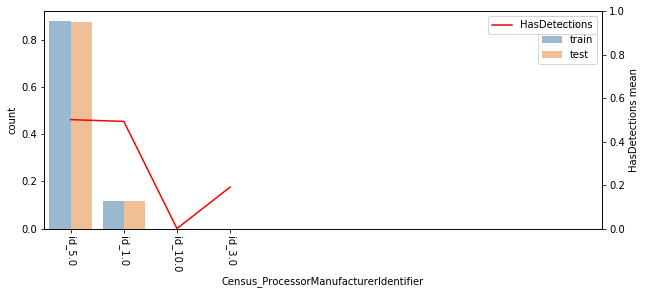

In [226]:
train_test_dist(sample_df, test_df, 'Census_ProcessorManufacturerIdentifier')
train_test_dist(identifier_sample, identifier_test, 'Census_ProcessorManufacturerIdentifier', target_name='HasDetections',disp_num=10)

### Census_OSInstallLanguageIdentifier

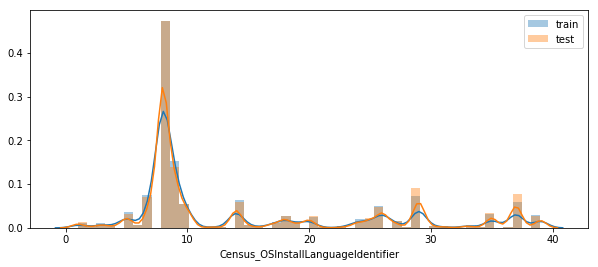

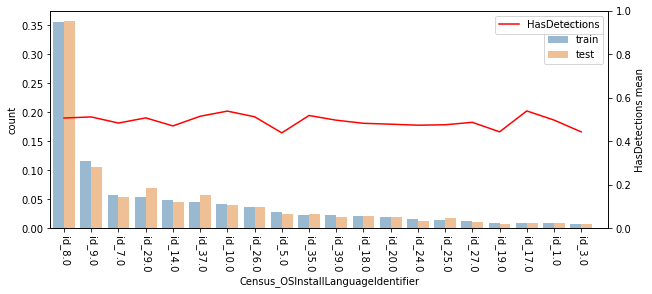

In [227]:
train_test_dist(sample_df, test_df, 'Census_OSInstallLanguageIdentifier')
train_test_dist(identifier_sample, identifier_test, 'Census_OSInstallLanguageIdentifier', target_name='HasDetections',disp_num=20)

### Census_OSUILocaleIdentifier

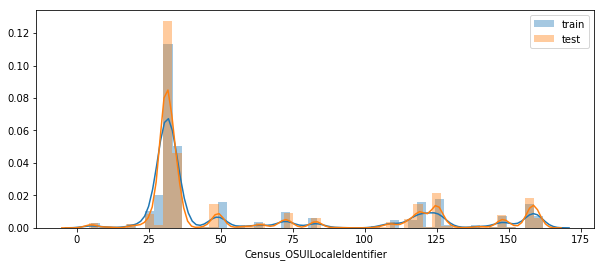

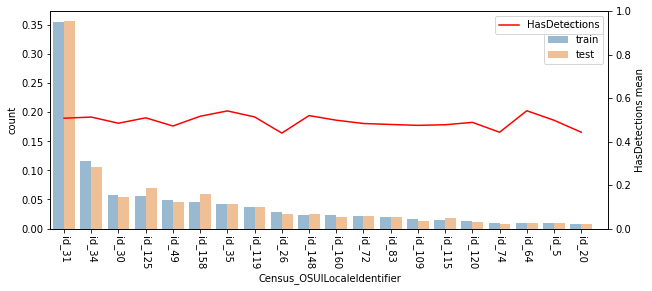

In [228]:
train_test_dist(sample_df, test_df, 'Census_OSUILocaleIdentifier')
train_test_dist(identifier_sample, identifier_test, 'Census_OSUILocaleIdentifier', target_name='HasDetections',disp_num=20)

### Census_FirmwareManufacturerIdentifier

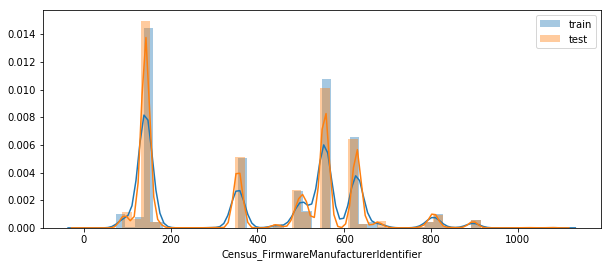

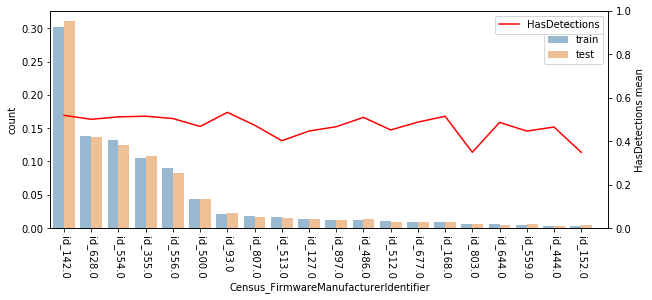

In [229]:
train_test_dist(sample_df, test_df, 'Census_FirmwareManufacturerIdentifier')
train_test_dist(identifier_sample, identifier_test, 'Census_FirmwareManufacturerIdentifier', target_name='HasDetections',disp_num=20)

### Wdft_RegionIdentifier

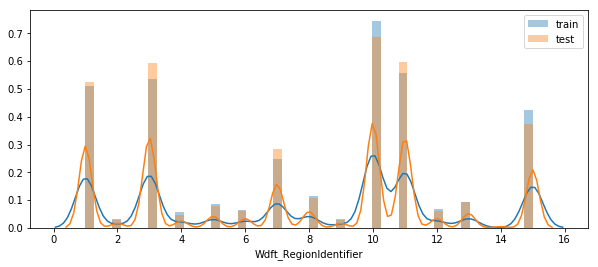

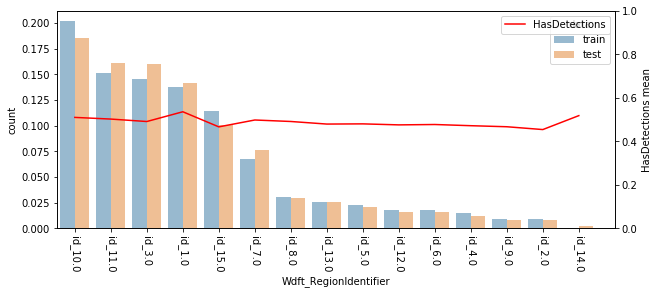

In [232]:
train_test_dist(sample_df, test_df, 'Wdft_RegionIdentifier')
train_test_dist(identifier_sample, identifier_test, 'Wdft_RegionIdentifier', target_name='HasDetections',disp_num=15)

## Transformer テスト

In [60]:
from sklearn.compose import ColumnTransformer
import category_encoders as ce

In [61]:
version_cols = ['AppVersion','EngineVersion','AvSigVersion','Census_OSVersion','OsVer']
identifier_cols = [elem for elem in sample_df.columns  if 'Identifier' in elem]
identifier_cols.remove('MachineIdentifier')
features = train_df.columns.drop('MachineIdentifier').drop('HasDetections')

In [62]:
column_trans = ColumnTransformer( transformers=[
    ('freq_arg_encode', t4k.transformer.FreqEncoder(), features),
    ('freq_encode', t4k.transformer.FreqArgEncoder(), features),
    ('version_encode', t4k.transformer.VersionEncoder(), version_cols),
    ('target_encode', ce.TargetEncoder(cols=identifier_cols,
                drop_invariant=True,
                handle_unknown='ignore',
                min_samples_leaf=int(train_df.shape[0] * 0.025)), identifier_cols)],
    remainder='drop')

In [63]:
sample_df_part1 = train_df.loc[:1000,:]
sample_df_part2 = train_df.loc[1000:2000,:].reset_index().drop('index',axis=1)
encoded_part1 = column_trans.fit_transform(
    sample_df_part1.drop('HasDetections', axis=1),
    sample_df_part1.HasDetections)

In [64]:
encoded_part2 = column_trans.transform(
    sample_df_part2.drop('HasDetections', axis=1))

In [65]:
pd.DataFrame(encoded_part2)

,0,1,2,3,4,5,6,7,8,9,...,157,158,159,160,161,162,163,164,165,166
0,0.99001,0.414585,0.568432,0.004995,1.0,0.972028,0.982018,-1.000000,0.676324,0.715285,...,0.0,0.0,0.0,0.0,0.0,4.180181e+12,127510010.0,1.001713e+12,11152001.0,10000.0
1,0.99001,0.414585,0.020979,0.002997,1.0,0.972028,0.982018,-1.000000,0.676324,0.715285,...,0.0,0.0,0.0,1.0,1.0,4.131713e+12,127514420.0,1.001713e+12,11152001.0,10000.0
2,0.99001,0.433566,0.568432,0.000000,1.0,0.972028,0.982018,-1.000000,0.676324,0.715285,...,0.0,0.0,0.0,1.0,3.0,4.180181e+12,127311120.0,1.001713e+12,11151001.0,10000.0
3,0.99001,0.414585,0.030969,0.000000,1.0,0.020979,0.982018,-1.000000,-1.000000,0.259740,...,0.0,0.0,0.0,0.0,1.0,4.100021e+12,127511040.0,1.001059e+12,11152001.0,6300.0
4,0.99001,0.433566,0.568432,0.001998,1.0,0.972028,0.982018,-1.000000,0.676324,0.715285,...,0.0,0.0,1.0,1.0,5.0,4.180181e+12,127318090.0,1.001713e+12,11151001.0,10000.0
5,0.99001,0.433566,0.568432,0.002997,1.0,0.972028,0.982018,-1.000000,0.002997,0.259740,...,0.0,0.0,0.0,1.0,0.0,4.180181e+12,127317350.0,1.001713e+12,11151001.0,10000.0
6,0.99001,0.433566,0.568432,0.000000,1.0,0.972028,0.982018,-1.000000,0.676324,0.715285,...,0.0,0.0,0.0,1.0,0.0,4.180181e+12,127316010.0,1.001713e+12,11151001.0,10000.0
7,0.99001,0.414585,0.568432,0.000000,1.0,0.972028,0.982018,-1.000000,0.676324,0.715285,...,0.0,0.0,0.0,0.0,3.0,4.180181e+12,127507710.0,1.001713e+12,11152001.0,10000.0
8,0.99001,0.433566,0.041958,0.003996,1.0,0.972028,0.982018,-1.000000,0.676324,0.715285,...,0.0,0.0,0.0,0.0,13.0,4.121630e+12,127308100.0,1.001630e+12,11151001.0,10000.0
9,0.99001,0.005994,0.568432,0.000000,1.0,0.972028,0.982018,-1.000000,0.676324,0.715285,...,0.0,0.0,0.0,1.0,1.0,4.180181e+12,127514780.0,1.001630e+12,11153005.0,10000.0
